# Postprocess ISIMIP3b precipitation and temperature data: merging, monthly means and standard deviation!

**the processed monthly data are available under: https://cluster.klima.uni-bremen.de/~lschuster/isimip3b/**

- see the fact sheet of isimip3b for more information: https://www.isimip.org/documents/413/ISIMIP3b_bias_adjustment_fact_sheet_VGtWmOp.pdf
    - there you can also find how to cite the used data
- the individual files were downloaded via a wget-script that was produced from https://esg.pik-potsdam.de/search/isimip/:

`bash isimip3b/wget-isimip3b_prcp_temp.sh -H`
(you need to registrate to esg and login via terminal)

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
scenarios = ['historical', 'ssp126', 'ssp370', 'ssp585']
# there are 5 gcms available 
gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
# two variables: bias-adjusted precipitation and near-surface temperature
typs =['prAdjust', 'tasAdjust']


In [3]:
run = False
if run:
    for gcm in gcms:
        if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
            ensemble = 'r1i1p1f1'
        elif gcm == 'ukesm1-0-ll':
            ensemble = 'r1i1p1f2'

        start = time.time()
        for scenario in scenarios:
            if scenario == 'historical':
                ybegin = 1850
                yend = 2014
            else:
                # for the ssp:
                ybegin = 2015
                yend = 2100
            for typ in typs:

                print(gcm, ensemble, scenario, typ)
                folder_output = 'isimip3b_{}_monthly'.format(typ)
                path_input = 'isimip3b/{}_{}_w5e5_{}_{}_global_daily_*.nc'.format(gcm, ensemble, scenario, typ)
                path_output = 'isimip3b/{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, typ, ybegin, yend)
                # open all at once
                ds = xr.open_mfdataset(path_input, concat_dim='time')

                # resample by monthly means, time stamp is of first day of the month
                ds_monthly = ds.resample(time='MS', keep_attrs=True).mean(keep_attrs=True)

                # add some postprocessing attributes
                ds_monthly.attrs['postprocessing_date'] = str(np.datetime64('today','D'))
                ds_monthly.attrs['postprocessing_scientist'] = 'lilian.schuster@student.uibk.ac.at'
                ds_monthly.attrs['postprocessing_actions'] =  ("using xarray: ds = xr.open_mfdataset({}, concat_dim='time') \n"
                                                                  "ds_monthly = ds.resample(time='MS', keep_attrs=True).mean(keep_attrs=True)\n"
                                                                  "ds_monthly.to_netcdf({})\n".format(path_input, path_output))
                # save the file
                ds_monthly.to_netcdf(path_output)

                # if temperature as variable, also compute daily temperature std for each month and save it
                if typ == 'tasAdjust':
                    folder_output_std = 'isimip3b_{}_std_monthly'.format(typ)
                    path_output_std = 'isimip3b/{}/{}_{}_w5e5_{}_{}_std_global_monthly_{}_{}.nc'.format(folder_output_std, gcm, ensemble, scenario, typ, ybegin, yend)

                    ds_tas_daily_std = ds.resample(time='MS', keep_attrs=True).std(keep_attrs=True)
                    ds_tas_daily_std = ds_tas_daily_std.rename_vars(dict(tasAdjust='tasAdjust_std'))
                    # now have to change variable tas to tas_std and its attributes 
                    ds_tas_daily_std.tasAdjust_std.attrs['standard_name'] = 'air_temperature_daily_std'
                    ds_tas_daily_std.tasAdjust_std.attrs['long_name'] = 'Near-Surface Air Temperature daily standard deviation'
                    ds_tas_daily_std.attrs['postprocessing_date'] = str(np.datetime64('today','D'))
                    ds_tas_daily_std.attrs['postprocessing_scientist'] = 'lilian.schuster@student.uibk.ac.at'
                    ds_tas_daily_std.attrs['postprocessing_actions'] =  ("using xarray: ds = xr.open_mfdataset({}, concat_dim='time') \n"
                                                                      "ds_tas_daily_std = ds.resample(time='MS', keep_attrs=True).std(keep_attrs=True)\n"
                                                                       "ds_tas_daily_std = ds_tas_daily_std.rename_vars(dict(tasAdjust='tasAdjust_std'))\n"
                                                                       "ds_tas_daily_std.tasAdjust_std.attrs['standard_name'] = 'air_temperature_daily_std'\n"
                                                                       "ds_tas_daily_std.tasAdjust_std.attrs['long_name'] = 'Near-Surface Air Temperature daily standard deviation'\n"
                                                                      "ds_tas_daily_std.to_netcdf({})\n".format(path_input, path_output_std))
                    ds_tas_daily_std.to_netcdf('{}'.format(path_output_std))                

        end = time.time()
        print('elapsed time: {} minutes'.format((end - start)/60))
# this produces in total ~75 GB with 60 files (20 files per variable)

## do some simple checks on the newly generated monthly datasets:

In [5]:
dict_global_pr_mean= {}
dict_global_tas_mean= {}

for gcm in gcms:
    if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
        ensemble = 'r1i1p1f1'
    elif gcm == 'ukesm1-0-ll':
        ensemble = 'r1i1p1f2'
    for scenario in scenarios:
        print(gcm, ensemble, scenario)

        if scenario == 'historical':
            ybegin = 1850
            yend = 2014
        else:
            ybegin = 2015
            yend = 2100    

        typ = 'prAdjust'
        folder_output = 'isimip3b_{}_monthly'.format(typ)
        path_output_pr = 'isimip3b/{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, typ, ybegin, yend)
        typ = 'tasAdjust'
        folder_output = 'isimip3b_{}_monthly'.format(typ)
        path_output_tas = 'isimip3b/{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, typ, ybegin, yend)
        folder_output_std = 'isimip3b_{}_std_monthly'.format(typ)
        path_output_tas_std = 'isimip3b/{}/{}_{}_w5e5_{}_{}_std_global_monthly_{}_{}.nc'.format(folder_output_std, gcm, ensemble, scenario, typ, ybegin, yend)


        ds_pr_monthly = xr.open_dataset(path_output_pr)
        ds_tas_monthly = xr.open_dataset(path_output_tas)
        ds_tas_daily_std = xr.open_dataset(path_output_tas_std)

        # right temperature boundaries? actual limits from bias adjustment are: [183.15, 343.15]
        assert np.all(ds_tas_monthly.tasAdjust > 183)  # unit is in K
        assert np.all(ds_tas_monthly.tasAdjust < 344)  # unit is in K

        # right temperature standard deviation
        assert np.all(ds_tas_daily_std.tasAdjust_std >= 0) # std should be above/equal zero
        assert np.all(ds_tas_daily_std.tasAdjust_std.max() < 50) # not too strong differences in between the days of one month

        # right precipitation boundaries?
        # prcp flux: unit is in kg m-2 s-1 (actual limits from bias adjustment are ~ [0, 0.007])
        assert np.all(ds_pr_monthly.prAdjust < 0.007)
        assert np.all(ds_pr_monthly.prAdjust >= 0)

        ### check the global mean temperature and precipitation time series
        # weighted average over latitudes
        weight = np.cos(np.deg2rad(ds_pr_monthly.lat))
        weight = weight / weight.sum()

        # get the global means for every month:
        global_pr_mean = (ds_pr_monthly.prAdjust.mean(dim='lon') * weight).sum(dim='lat').resample(time='1Y').mean() *60*60*24  # from kg /m2 /s to  mm/day
        global_tas_mean = (ds_tas_monthly.tasAdjust.mean(dim='lon') * weight).sum(dim='lat').resample(time='1Y').mean() - 273.15  # from K to °C
        print('global precipitation mean: {} mm/day \nglobal temperature mean: {} °C'.format(global_pr_mean.mean().values.round(2), global_tas_mean.mean().values.round(2)))
        # check if they are approximately equal to literature values
        np.testing.assert_allclose(global_pr_mean, 2.6, #  around 2.5-2.7 mm/day on global annual mean
                                   atol = 1.3) # allow to be 2.6 +/- 1.3
        np.testing.assert_allclose(global_tas_mean, 14, # °C  (20th century average)
                                   atol = 10)  # allow to be 14 +/- 10

        dict_global_pr_mean['{}_{}'.format(gcm, scenario)] = global_pr_mean
        dict_global_tas_mean['{}_{}'.format(gcm, scenario)] = global_tas_mean




gfdl-esm4 r1i1p1f1 historical
global precipitation mean: 2.69 mm/day 
global temperature mean: 13.97 °C
gfdl-esm4 r1i1p1f1 ssp126
global precipitation mean: 2.73 mm/day 
global temperature mean: 15.13 °C
gfdl-esm4 r1i1p1f1 ssp370
global precipitation mean: 2.7 mm/day 
global temperature mean: 15.9 °C
gfdl-esm4 r1i1p1f1 ssp585
global precipitation mean: 2.73 mm/day 
global temperature mean: 16.1 °C
ipsl-cm6a-lr r1i1p1f1 historical
global precipitation mean: 2.66 mm/day 
global temperature mean: 13.67 °C
ipsl-cm6a-lr r1i1p1f1 ssp126
global precipitation mean: 2.73 mm/day 
global temperature mean: 15.49 °C
ipsl-cm6a-lr r1i1p1f1 ssp370
global precipitation mean: 2.76 mm/day 
global temperature mean: 16.51 °C
ipsl-cm6a-lr r1i1p1f1 ssp585
global precipitation mean: 2.78 mm/day 
global temperature mean: 17.0 °C
mpi-esm1-2-hr r1i1p1f1 historical
global precipitation mean: 2.67 mm/day 
global temperature mean: 13.8 °C
mpi-esm1-2-hr r1i1p1f1 ssp126
global precipitation mean: 2.71 mm/day 
global 

**check the global mean time series by a plot**

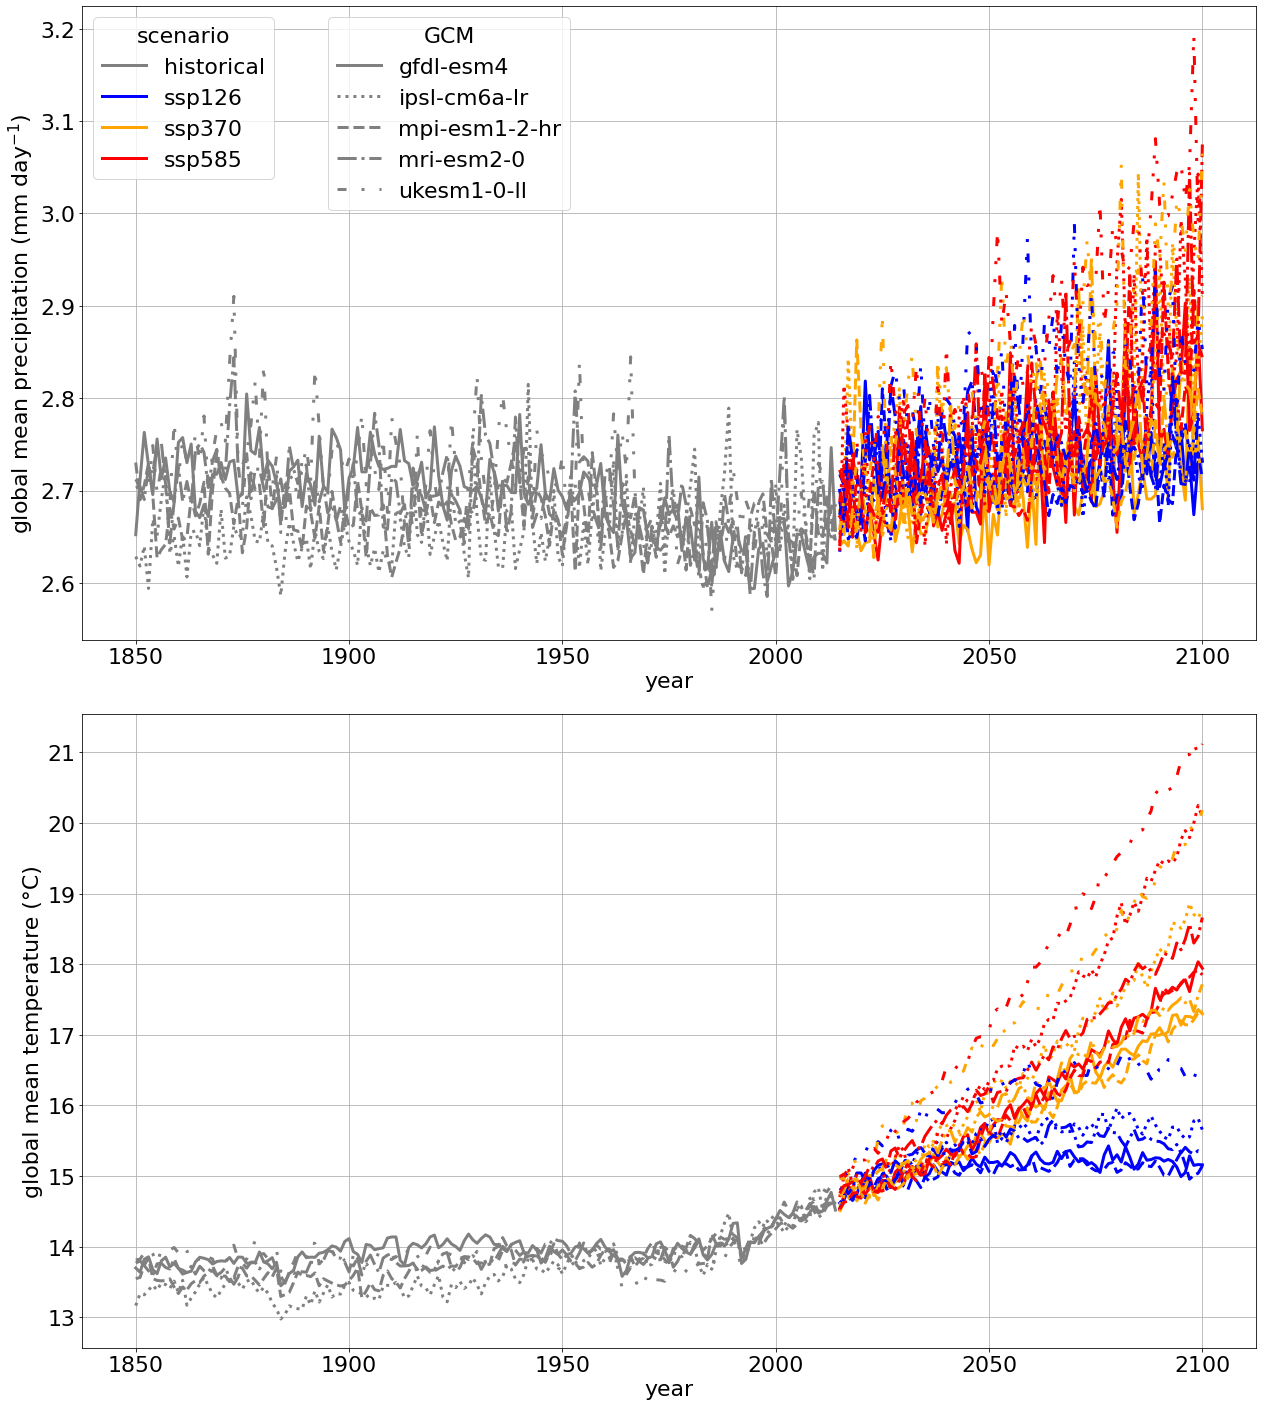

In [8]:
plt.rcParams.update({'font.size': 22})
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,20))

lss = ['-',':', '--', '-.', (0, (3, 5, 1, 5, 1, 5))]
for gcm, ls in zip(gcms,lss): 
    # visual test:
    for scenario, c in zip(scenarios, ['grey', 'blue', 'orange', 'red']):
        if scenario == 'historical':
            yr = np.arange(1850, 2015)
        else:
            yr = np.arange(2015, 2101)
        # ax1 = plt.subplot(2,1,1)
        ax1.plot(yr, dict_global_pr_mean['{}_{}'.format(gcm, scenario)],
                 label = '{}'.format(scenario), color = c, ls =ls, lw=3)
        ax1.set_ylabel(r'global mean precipitation (mm day$^{-1}$)')
        ax1.set_xlabel('year')
        if ls == '-':
            legend1 = ax1.legend(loc=2, title = 'scenario')
        # ax2.subplot(2,1,2)
        ax2.plot(yr, dict_global_tas_mean['{}_{}'.format(gcm, scenario)],
                 label = '{}_{}'.format(gcm, scenario), color = c, ls = ls, lw=3)
        ax2.set_ylabel('global mean temperature (°C)')
        ax2.set_xlabel('year')
lines = ax1.get_lines()
legend2 = ax1.legend(lines[::4], gcms , loc=2, bbox_to_anchor=(0.2,1), title='GCM')
ax1.add_artist(legend1)
plt.tight_layout()
ax1.grid()
ax2.grid()

plt.savefig('isimip3b/plot_global_mean_time_series_test.pdf');

### check if the files are equal to those from Harry Zekollari

In [9]:
gcm = 'ipsl-cm6a-lr'
ensemble = 'r1i1p1f1'
scenario = 'historical'
ybegin = 1850
yend = 2014

typ = 'prAdjust'
folder_output = 'isimip3b_{}_monthly'.format(typ)
path_output_pr = 'isimip3b/{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, typ, ybegin, yend)
typ = 'tasAdjust'
folder_output = 'isimip3b_{}_monthly'.format(typ)
path_output_tas = 'isimip3b/{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, typ, ybegin, yend)
folder_output_std = 'isimip3b_{}_std_monthly'.format(typ)
path_output_tas_std = 'isimip3b/{}/{}_{}_w5e5_{}_{}_std_global_monthly_{}_{}.nc'.format(folder_output_std, gcm, ensemble, scenario, typ, ybegin, yend)


my_pr_monthly = xr.open_dataset(path_output_pr)
my_tas_monthly = xr.open_dataset(path_output_tas)

In [10]:
test_pr = xr.open_dataset('isimip_test_zekollari/ipsl-cm6a-lr_r1i1p1f1_w5e5_historical_prAdjust_global_monthly_1850_2014.nc')
test_tas = xr.open_dataset('isimip_test_zekollari/ipsl-cm6a-lr_r1i1p1f1_w5e5_historical_tasAdjust_global_monthly_1850_2014.nc')

In [11]:
my_pr_monthly

<xarray.Dataset>
Dimensions:   (lat: 360, lon: 720, time: 1980)
Coordinates:
  * time      (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2014-12-01
  * lon       (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat       (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
Data variables:
    prAdjust  (time, lat, lon) float32 ...
Attributes:
    title:                     ISIMIP3b bias-adjusted climate input data
    institution:               Potsdam Institute for Climate Impact Research ...
    contact:                   ISIMIP cross-sectoral science team <info@isimi...
    summary:                   CMIP6 daily output data bias-adjusted and stat...
    version:                   This file was published on 19 June 2020, see <...
    project:                   isimip3b
    product:                   input
    dataset_type:              Climate atmosphere simulated
    bias_correction:           W5E5-ISIMIP3BASD2
    world_region:              Global
    country:                   ALL
    time_frequency:            day
    model:                     IPSL-CM6A-LR
    experiment:                historical
    ensemble:                  r1i1p1f1
    publisher:                 ISIMIP coordination team <info@isimip.org>
    description:               IPSL-CM6A-LR bias corrected impact model input...
    doi:                       NA
    licence:                   CC BY 4.0
    creator:                   ISIMIP Coordination Team <info@isimip.org>
    tracking_id:               a4f335a4-403f-44d2-be45-d1f3eff0f563
    creation_date:             2020-06-20T01:53:26Z
    postprocessing_date:       2021-02-25
    postprocessing_scientist:  lilian.schuster@student.uibk.ac.at
    postprocessing_actions:    using xarray: ds = xr.open_mfdataset(isimip3b/...

In [12]:
test_pr

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 360, lon: 720, time: 1980)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon        (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat        (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    prAdjust   (time, lat, lon) float32 ...
Attributes:
    CDI:              Climate Data Interface version 1.9.2 (http://mpimet.mpg...
    history:          Tue Feb 23 15:59:26 2021: cdo mergetime prec1.nc prec10...
    institution:      Potsdam Institute for Climate Impact Research (PIK)
    Conventions:      CF-1.6
    title:            ISIMIP3b bias-adjusted climate input data
    contact:          ISIMIP cross-sectoral science team <info@isimip.org> <h...
    summary:          CMIP6 daily output data bias-adjusted and statistically...
    version:          This file was published on 19 June 2020, see <https://w...
    project:          isimip3b
    product:          input
    dataset_type:     Climate atmosphere simulated
    bias_correction:  W5E5-ISIMIP3BASD2
    world_region:     Global
    country:          ALL
    time_frequency:   day
    model:            IPSL-CM6A-LR
    experiment:       historical
    ensemble:         r1i1p1f1
    publisher:        ISIMIP coordination team <info@isimip.org>
    description:      IPSL-CM6A-LR bias corrected impact model input prepared...
    doi:              NA
    licence:          CC BY 4.0
    creator:          ISIMIP Coordination Team <info@isimip.org>
    tracking_id:      a4f335a4-403f-44d2-be45-d1f3eff0f563
    creation_date:    2020-06-20T01:53:26Z
    frequency:        mon
    CDO:              Climate Data Operators version 1.9.2 (http://mpimet.mpg...

they have the same shape, except that "my" files don't have a time_bnds but I don't think that this is necessary 

the values are also the same:

In [13]:
np.testing.assert_allclose(my_pr_monthly.prAdjust.values, test_pr.prAdjust.values, rtol = 1e-6)

In [14]:
np.testing.assert_allclose(my_tas_monthly.tasAdjust.values, test_tas.tasAdjust.values, rtol = 1e-6)